<a href="https://colab.research.google.com/github/gaurav1030332018/cancerdetection/blob/main/efficientdetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/drive/MyDrive/kaggle dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/kaggle dataset/kaggle.json
/content/drive/MyDrive/kaggle dataset/final_model.h5
/content/drive/MyDrive/kaggle dataset/my_model2.h5
/content/drive/MyDrive/kaggle dataset/train_and_test2.csv
/content/drive/MyDrive/kaggle dataset/brain-tumor-classification-mri.zip
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor/image(10).jpg
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor/image(1).jpg
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor/image(11).jpg
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor/image(17).jpg
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor/image(12).jpg
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor/image(100).jpg
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor/image(14).jpg
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor/image(15).jpg
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor/image(18).jpg
/content/drive/MyDrive/kaggle dataset/Testing/glioma_tumor

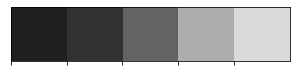

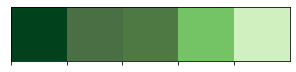

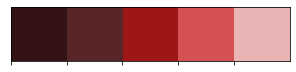

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/kaggle dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
    #  print(j)
      try:
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
      except Exception as e:
        pass

        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/kaggle dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 80.22it/s]


In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [6]:
X_train.shape
#y_train.shape

(3263, 150, 150, 3)

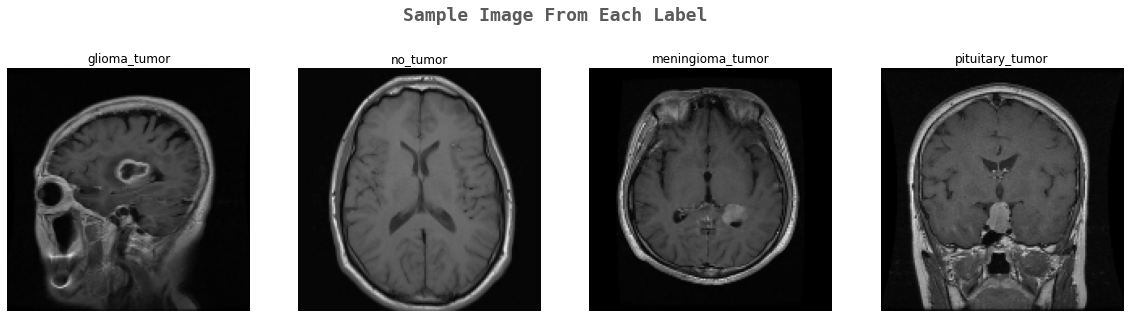

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [9]:
X_train.shape

(3263, 150, 150, 3)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)#it will save best model only
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [17]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.8176
Epoch 00001: val_accuracy improved from -inf to 0.86395, saving model to effnet.h5
83/83 [==============================] - 43s 350ms/step - loss: 0.4933 - accuracy: 0.8176 - val_loss: 0.4941 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9311
Epoch 00002: val_accuracy did not improve from 0.86395
83/83 [==============================] - 25s 296ms/step - loss: 0.1982 - accuracy: 0.9311 - val_loss: 0.5715 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9603
Epoch 00003: val_accuracy improved from 0.86395 to 0.90476, saving model to effnet.h5
83/83 [==============================] - 26s 308ms/step - loss: 0.1164 - accuracy: 0.9603 - val_loss: 0.4979 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 4/20
83/83 [==============================] - ETA: 0s

In [18]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1) #preidcted values
y_test_new = np.argmax(y_test,axis=1) #original values

In [19]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        89
           1       1.00      1.00      1.00        54
           2       0.91      0.93      0.92        91
           3       0.96      1.00      0.98        93

    accuracy                           0.96       327
   macro avg       0.96      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



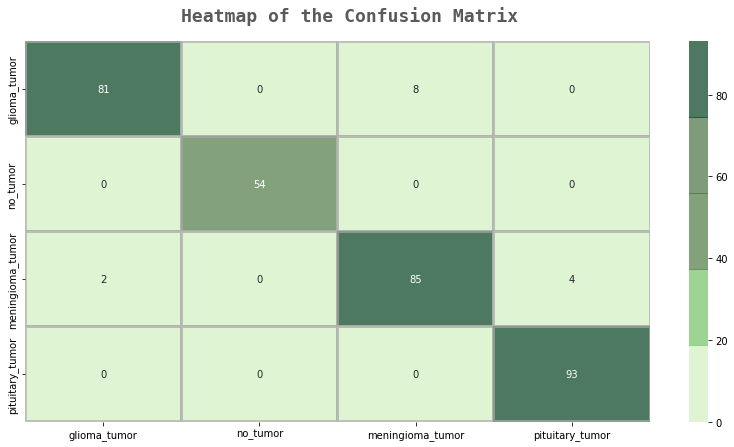

In [20]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [21]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [22]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [23]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])